Authored by *Tyler Norlund* and *Edwin Ramirez*

# Machine Learning HW3
**Clustering and Radial Basis Functions**

In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

## Problem 1

In this problem you will use the data file “kMeansData.csv” ($x_1$ and $x_2$ denote the input features) to create 3 clusters using unsupervised Lloyd’s k-means algorithm.

The training should only stop if the difference between the cluster center locations in two consecutive iterations is less than 0.001 or if the number of iterations has reached 1000. For the initial selection of cluster locations choose 3 points from the data set randomly.

After convergence, report the final cluster centers. Plot the 3 clusters in different colors with cluster centers clearly marked on the plot.

*Answer*

In order to implement Lloyd's k-means algorithm, we need to:
1. Generate the random centers
2. 

In [2]:
#read in data
df = pd.read_csv('kMeansData.csv')

#Create class column, and set all values to Nan
#Classes have not been defined yet
df['class'] = np.nan

Data contains x1, and x2 points along with the class column. The objective is to pick 3 random centers in the plot of our data from which we will utilize to classify all other points into a class. 

In [3]:
df.head()

,x1,x2,class
0,1.4,0.2,NaN
1,1.4,0.2,NaN
2,1.3,0.2,NaN
3,1.5,0.2,NaN
4,1.4,0.2,NaN


In [4]:
def get_centers(num, df):
    #Randomly pick num center points within the dataset
    random.seed(11)
    centers = [(random.uniform(df.x1.min(), df.x1.max()), random.uniform(df.x2.min(), df.x2.max()))for i in range(num)]
    return centers

In [5]:
centers = get_centers(3, df)
centers

[(3.66903936570793, 1.4434537265931904),
 (6.4528424457400035, 1.2175601682394561),
 (3.9962635110674, 1.5097235892397527)]

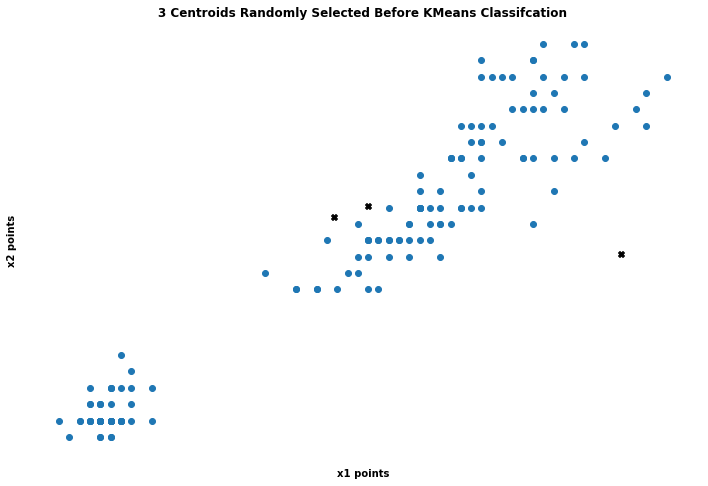

In [6]:
def plot_clusters(classes, df, centers):
    
    num = str(len(centers))
    fig, ax = plt.subplots(figsize = (12.0, 8.0))
    if classes:
        for ii in range(len(centers)):
            ax.scatter(df[df['class'] == ii].x1, df[df['class'] == ii].x2)
        ax.set_title("KMeans Classifcation of "+ num + " Clusters", weight="bold")
    else:
        ax.scatter(df.x1, df.x2)
        ax.set_title( num + " Centroids Randomly Selected Before KMeans Classifcation", weight="bold")
    [ax.scatter(center[0], center[1], marker='X', c='k') for center in centers]
    sns.despine(left=True, bottom=True)
    ax.tick_params(bottom=False, left=False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlabel("x1 points", weight = "bold")
    ax.set_ylabel("x2 points", weight = "bold")
    plt.show()
plot_clusters(False, df, centers)

The Euclidean distance of each point to each centroid will be used to classify each point. The centroid that has the smallest distance to the test point will be usedt to classify the new point. 

$$\sqrt{
    (x_{1} - \texttt{center}_1)^{2} + 
    (x_{2} - \texttt{center}_2)^{2}
} $$

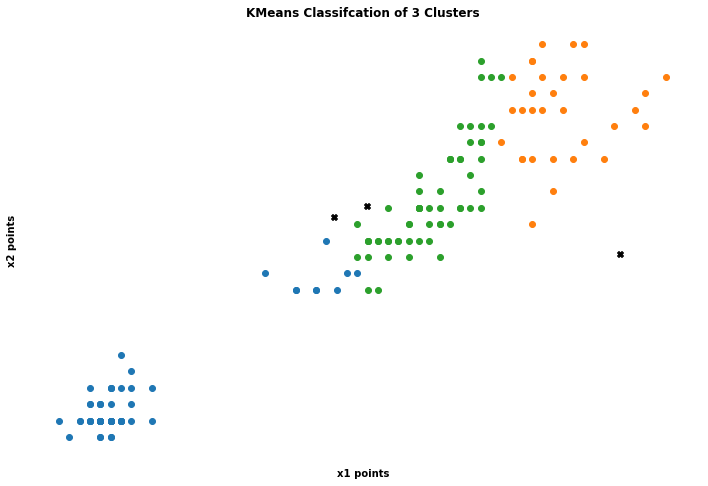

In [7]:
def get_classes(data_point, center_points):
    #compute distance to all 3 centers, return the min index as classification
    c = [ ((data_point.x1 - i[0])**2 + (data_point.x2 - i[1])**2)**0.5  for i in center_points]
    return np.argmin(c)

#classify all points
df['class'] = [get_classes(df.iloc[i],centers) for i in range(0, len(df.x1))]
plot_clusters(True, df, centers)

Look at that! We were able to classify each point with a certain class. We can now update the centers to be in the centroid of each class. The assignment requires us to update the centers only if the delta is less than 0.001. The process will be:
1. Update the centers
2. Calculate the delta
3. Compare the previous two deltas
4. Repeat if the conditions are not meet

In [8]:
def get_delta(num_centers, prev_centers, new_centers):
    
    #compute error to previous centers
    dist = [((new_centers[i][0] - prev_centers[i][0])**2 + (new_centers[i][1] - prev_centers[i][1])**2) for i in range(num_centers)]
    
    #check that old and new centers are within 0.001 distance of each other
    err = [i < 0.001 for i in dist]
    return err

In [9]:
for i in range(1000):
    #previous centers
    prev_centers = centers
    #compute new centers
    centers = [(df[df['class'] == i].x1.mean(), df[df['class'] == i].x2.mean()) for i in range(3)]
    #compute new classes
    df['class'] = [get_classes(df.iloc[i], centers) for i in range(0, len(df.x1))]
    
    res = get_delta(3, prev_centers, centers)
    iterations = i
    cond = [True, True, True]
    if(res == cond):
        print(iterations+1)
        break

5


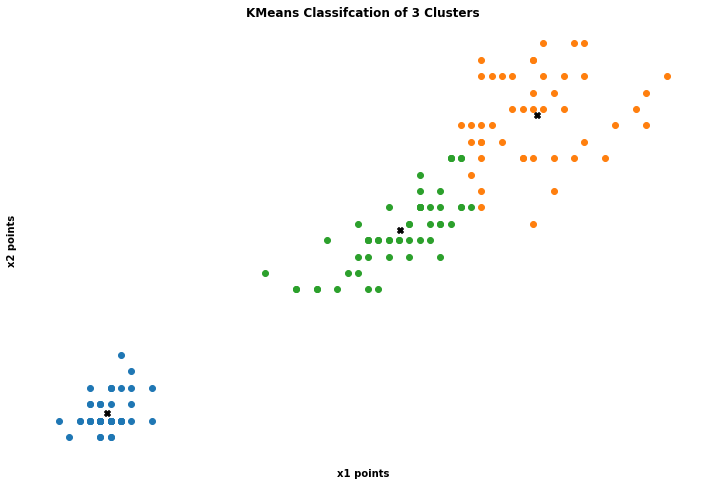

In [10]:
plot_clusters(True, df, centers)

## Problem 2

In this problem you will use the data file “rbfClassification.csv” to create an RBF classification model. $x_1$ and $x_2$ denote the input features and cls denotes the target class of the corresponding data points.

### 1

Use k-means clustering to determine the location of 2 cluster centers that you will use in your RBF model. Report the coordinate of the cluster centers.

*Answer*

In [11]:
rbf = pd.read_csv("rbfClassification.csv")

In [12]:
rbf.head()

,x1,x2,cls
0,-2.427236,1.965984,1
1,2.382605,2.256614,0
2,-2.680668,2.379979,1
3,-2.620277,2.913823,0
4,1.513792,-2.312650,0


In [13]:
rbf.columns = ["x1", "x2", "class"]

In [14]:
rbf.head()

,x1,x2,class
0,-2.427236,1.965984,1
1,2.382605,2.256614,0
2,-2.680668,2.379979,1
3,-2.620277,2.913823,0
4,1.513792,-2.312650,0


In [15]:
centers2 = get_centers(2, rbf)
centers2

[(-0.41890969618932594, 0.4799585701248432),
 (2.1969986804096218, -0.05222874338578043)]

### Uncentered 

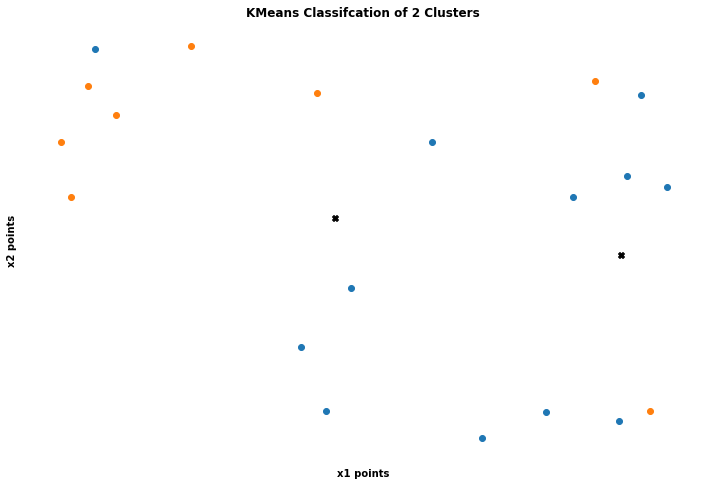

In [16]:
plot_clusters(True, rbf, centers2)

## Centered

In [17]:
for i in range(1000):
    #previous centers
    prev_centers = centers2
    #compute new centers
    centers2 = [(rbf[rbf['class'] == i].x1.mean(), rbf[rbf['class'] == i].x2.mean()) for i in range(2)]
    #compute new classes
    rbf['class'] = [get_classes(rbf.iloc[i], centers2) for i in range(0, len(rbf.x1))]
    
    res = get_delta(2, prev_centers, centers2)
    iterations = i
    cond = [True, True]
    if(res == cond):
        print(iterations+1)
        break

4


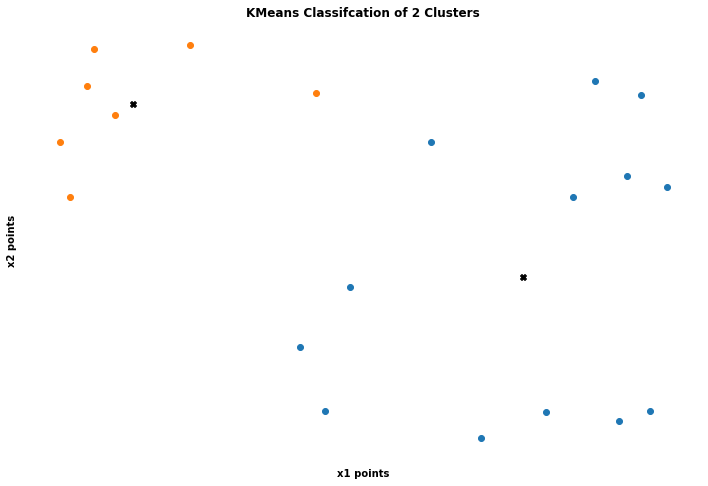

In [18]:
plot_clusters(True, rbf, centers2)

### 2

Train an RBF model using $\gamma = 0.5$. Report the correct classification rate of your model.

*Answer*

So! In order to solve for the RBF, we must define some variables. Let $\mu$ be the centers we found previously and $\gamma=0.5$. We can use the following estimation.

$$
\begin{bmatrix}
1 & e^{\gamma |X_{1} - \mu_{1} |^{2} } & e^{\gamma |X_{1} - \mu_{2} |^{2} } \\
1 & e^{\gamma |X_{2} - \mu_{1} |^{2} } & e^{\gamma |X_{2} - \mu_{2} |^{2} } \\
\vdots & \vdots & \vdots \\
1 & e^{\gamma |X_{N} - \mu_{1} |^{2} } & e^{\gamma |X_{N} - \mu_{2} |^{2} } \\
\end{bmatrix}
\begin{bmatrix}
w_{0} \\
w_{1} \\
w_{2}
\end{bmatrix}
\approx
\begin{bmatrix}
y_{0} \\
y_{1} \\
y_{2}
\end{bmatrix}
$$

To save space, we can rewrite the equation as:

$$
\Phi w \approx y \text{.}
$$

Now we can solve for $w$ using linear regression:

$$
w \approx (\Phi^{T}\Phi)^{-1}\Phi^{T} y \text{.}
$$

In [19]:
centers2

[(1.306410424076923, -0.37348593276923076),
 (-2.2601480715714284, 2.1265867955714284)]

In [20]:
centers2[0][0]

1.306410424076923

In [21]:
g = -0.5


phi = [(1, 
        np.exp(g*((rbf.iloc[i].x1 - centers2[0][0])**2 + (rbf.iloc[i].x2 - centers2[0][1])**2)),
        np.exp(g*((rbf.iloc[i].x1 - centers2[1][0])**2 + (rbf.iloc[i].x2 - centers2[1][1])**2)))
       for i in range(len(rbf.x1))]

In [22]:
phi = DataFrame(phi)

In [24]:
y = rbf["class"]

In [25]:
phi_inv = DataFrame(np.linalg.pinv(phi.values), phi.columns, phi.index)

### Compute w

In [27]:
w = phi_inv.dot(y)
w

0    0.132013
1   -0.539680
2    1.189886
dtype: float64

Alright! After solving for $w$, we can classify the points. We have 2 centers, $\mu$, and 3 weights, $w$. We can use $h(x)$ to classify each point. We must remember that the linear regression used a column of $1$'s, and we will substitute $1$ in the summation. 

$$
h(x) = \sum_{k=1}^{K} w_{k} e^{-\gamma |x - \mu_{k} |^{2}}
$$

After computing $h(x)$, we can look at the graph and see that some $h$ values are greater than 0.5. The ones greater than 0.5 will be classified as class 1, while the ones less than 0.5 are classified as class 0.

In [39]:
h = phi
h[0] = phi[0]*w[0]
h[1] = phi[1]*w[1]
h[2] = phi[2]*w[2]

In [40]:
len(h[0])

20

In [41]:
H = [sum(h.iloc[i]) for i in range(len(h[0]))]

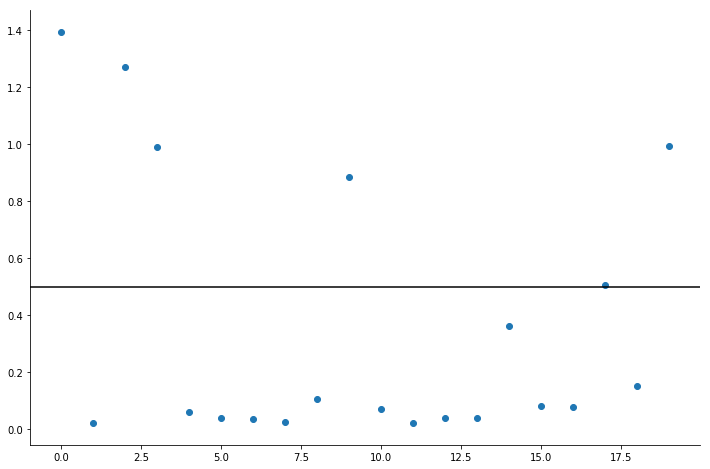

In [42]:
fig, ax = plt.subplots(figsize = (12.0, 8.0))
ax.scatter(range(20), H)
ax.axhline(y=0.5, color='k')
sns.despine()

In [43]:
def classify_points(point):
    if point > 0.5:
        cls = 1
    else:
        cls = 0
    
    return cls

In [44]:
predictions = [classify_points(H[i]) for i in range(len(H))]

In [45]:
predictions

[1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]

In [46]:
np.array(rbf["class"])

array([1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1],
      dtype=int64)

In [47]:
accuracy = sum(predictions == rbf["class"])/len(predictions)
accuracy

0.95

## Problem 3

The “stuFile.csv” is a list of students’ features at an academic institution that is considering starting a new program. The features include average yearly packaged financial aid, the number of years that the financial aid is awarded for, gender, marital status, marketing code, previous education, admission representative code, program code, citizenship code, ethnicity code, veteran code, and cancel flag code. Some of the students listed in the file cancelled their enrollment after meeting with Financial Aid. These students can be identified by the value of 1 in the cancel flag field.

This institution is considering starting a new program after researching the cannibalization rates, navigating regulatory requirements, and determining the potential market. There is an opportunity to market this program to students who cancelled before starting their originally intended program. The presump- tion is that the shorter duration and lower tuition rate of this program may be attractive to some students who cancelled.
Your task is to look into the data and provide some insight into who “might” enroll from this population using the clustering schemes discussed in class.

### 1

Use Value Metric Difference (VDM) to find and report the distance between the different levels of all categorical variables.

*Answer*

In [69]:
#Read in dataa file
df = pd.read_csv(filepath_or_buffer='stuFile.csv',index_col=0)

#Define the categorical variables in the dataset
cat_params = ['SexCode', 'MaritalCode', 'LeadCategoryCode', 
          'PrevEdCode', 'AdmRepName','ProgramCode', 'CitizenCode', 
          'IsHispanic', 'DDVeteran']
#Create a dictionary col_val that contains
#all column names as keys and all unique values
#associated with each key in a list
col_val = {}
for col in cat_params:
    col_val[col] = list(df[col].unique())

#Print each column and respective data types
[df.iloc[:,i].apply(type).value_counts() for i in range(df.shape[1])]

[<class 'int'>    2260
 Name: StuNum, dtype: int64, <class 'float'>    2260
 Name: avgYearPack, dtype: int64, <class 'int'>    2260
 Name: numYearAward, dtype: int64, <class 'str'>    2260
 Name: SexCode, dtype: int64, <class 'str'>    2260
 Name: MaritalCode, dtype: int64, <class 'str'>    2260
 Name: LeadCategoryCode, dtype: int64, <class 'str'>    2260
 Name: PrevEdCode, dtype: int64, <class 'int'>    2260
 Name: AdmRepName, dtype: int64, <class 'int'>    2260
 Name: ProgramCode, dtype: int64, <class 'str'>    2260
 Name: CitizenCode, dtype: int64, <class 'int'>    2260
 Name: IsHispanic, dtype: int64, <class 'int'>    2260
 Name: DDVeteran, dtype: int64, <class 'int'>    2260
 Name: cancelFlag.x, dtype: int64]

This dataset uses categorical variables for `SexCode`, `MaritalCode`, `LeadCategoryCode`, `PrevEdCode`, `AdmRepName`, `ProgramCode`, `CitizenCode`, `IsHispanic`, and `DDVeteran`. We will need to find the categorical probability of each of these parameters. The reason that we don't consider `StuNum` as a categorical variable is because each repective row/observation will have a unique case number. Therefore, we believe that it is unnecessary to reference this variable as a categorical variable or continuous in our analysis. This information is more appropriately used as index values in our dataset.

In [70]:
#Create empty dictionary to store 
#conditional probabilities for all categorical variables
prob = {}

#Compute the conditional probabilities 
#For all unique values in all categories
for param in cat_params:
    temp_1 = {}
    temp_2 = {}
    #Encode each categorical variable into numeric representation
    #df[param] = pd.factorize(df[param].astype('category'))[0]
    
    #For each unique value in each category
    #Compute the conditional probabilities
    for val in list(df[param].unique()):
        temp_1[val] = df[(df[param] == val) & (df['cancelFlag.x'] == 0)].shape[0]/df[df[param] == val].shape[0]
        temp_2[val] = df[(df[param] == val) & (df['cancelFlag.x'] == 1)].shape[0]/df[df[param] == val].shape[0]
    
    #Set param (the current categorical varaible) as a dictionary key 
    #Then store the conditional probabilities to this specific key
    prob[param] = {
        'not_cancel': temp_1,
        'cancel': temp_2}

In [71]:
prob

{'SexCode': {'not_cancel': {'F': 0.7883923985618901, 'M': 0.8370607028753994},
  'cancel': {'F': 0.21160760143810992, 'M': 0.16293929712460065}},
 'MaritalCode': {'not_cancel': {'UN': 0.9882352941176471,
   'S': 0.7941970310391363,
   'M': 0.7769230769230769,
   'D': 0.7522123893805309,
   'P': 0.7818181818181819,
   'W': 0.8},
  'cancel': {'UN': 0.011764705882352941,
   'S': 0.2058029689608637,
   'M': 0.2230769230769231,
   'D': 0.24778761061946902,
   'P': 0.21818181818181817,
   'W': 0.2}},
 'LeadCategoryCode': {'not_cancel': {'REF': 0.8379746835443038,
   'INTINT': 0.8034351145038168,
   'RADIO': 0.9416058394160584,
   'INTER': 0.7468354430379747,
   'PPC': 0.7254901960784313,
   'DIRMAIL': 0.6470588235294118,
   'PRINT': 0.7058823529411765,
   'OUTDOOR': 0.873015873015873,
   'EMAIL': 0.75,
   'PDSCLMDA': 0.5573770491803278,
   'TV': 0.6511627906976745,
   'BUSDEV': 1.0,
   'OTHER': 1.0,
   'DISPLAY': 0.5},
  'cancel': {'REF': 0.1620253164556962,
   'INTINT': 0.1965648854961832,


In [72]:
def computeDistances(categorical):
    not_cancel = categorical["not_cancel"]
    cancel = categorical["cancel"]
    cat_vals = cancel.keys()
    
    #Get the labels of the distance to be measured
    labels = [str(val) + "-" + str(val2) for val in cat_vals for val2 in cat_vals]
    
    #Compute all distances
    dist = [np.abs(cancel[val] - cancel[val2])**2 + np.abs(not_cancel[val] - not_cancel[val2])**2 
            for val in cat_vals for val2 in cat_vals]
    #Combine into a dictionary
    dist_dict = dict(zip(labels, dist))
    
    return dist_dict

In [73]:
#For every categorical variable compute all distances
all_cat_dists = [computeDistances(prob[category]) for category in cat_params]

In [74]:
#Store all distances to each respective category
cat_distances = dict(zip(cat_params, all_cat_dists))

In [75]:
#Test to verify all distances for "SexCode" were computed
#There should be 4 values with F-F and M-M as 0
cat_distances['SexCode']

{'F-F': 0.0,
 'F-M': 0.0047372076895046845,
 'M-F': 0.0047372076895046845,
 'M-M': 0.0}

The distances between the different levels for all categorical variables are listed below:

In [76]:
cat_distances

{'SexCode': {'F-F': 0.0,
  'F-M': 0.0047372076895046845,
  'M-F': 0.0047372076895046845,
  'M-M': 0.0},
 'MaritalCode': {'UN-UN': 0.0,
  'UN-S': 0.0753016950770507,
  'UN-M': 0.08930570627137038,
  'UN-D': 0.11141362312109158,
  'UN-P': 0.08521604850010009,
  'UN-W': 0.07086505190311418,
  'S-UN': 0.0753016950770507,
  'S-S': 0.0,
  'S-M': 0.0005967789816074495,
  'S-D': 0.003525420270403,
  'S-P': 0.0003064718160702497,
  'S-W': 6.734889752149538e-05,
  'M-UN': 0.08930570627137038,
  'M-S': 0.0005967789816074495,
  'M-M': 0.0,
  'M-D': 0.0012212361576506737,
  'M-P': 4.7924103868160265e-05,
  'M-W': 0.0010650887573964512,
  'D-UN': 0.11141362312109158,
  'D-S': 0.003525420270403,
  'D-M': 0.0012212361576506737,
  'D-D': 0.0,
  'D-P': 0.0017530058917225337,
  'D-W': 0.004567311457435986,
  'P-UN': 0.08521604850010009,
  'P-S': 0.0003064718160702497,
  'P-M': 4.7924103868160265e-05,
  'P-D': 0.0017530058917225337,
  'P-P': 0.0,
  'P-W': 0.0006611570247933879,
  'W-UN': 0.070865051903114

### 2

Use VDM along with other distance metrics for continuous features to cluster the data. Justify the number of clusters you have used. Use Elbow plot.

*Answer*

In [77]:
len(cat_distances)

9

## Normalization of Continuous Data

We have to remember to first normalize all of our continuous variables thus we decide to do use mean normalization. Our continuous variables include `avgYearPack` and `numYearAward`.

In [78]:
df.columns

Index(['StuNum', 'avgYearPack', 'numYearAward', 'SexCode', 'MaritalCode',
       'LeadCategoryCode', 'PrevEdCode', 'AdmRepName', 'ProgramCode',
       'CitizenCode', 'IsHispanic', 'DDVeteran', 'cancelFlag.x'],
      dtype='object')

In [79]:
df.head()

,StuNum,avgYearPack,numYearAward,SexCode,MaritalCode,LeadCategoryCode,PrevEdCode,AdmRepName,ProgramCode,CitizenCode,IsHispanic,DDVeteran,cancelFlag.x
1,11800,23969.333333,3,F,UN,REF,SOMECOLL,19,2,US,2,0,0
2,11221,36718.000000,2,F,S,INTINT,SOMECOLL,15,2,US,1,0,0
3,11244,7710.000000,2,F,M,REF,ASSOC,30,2,US,2,0,1
4,12015,27188.200000,2,M,M,INTINT,BACH,7,1,US,2,0,0
5,11122,24804.943333,3,F,S,RADIO,BACH,15,2,US,2,1,0


In [80]:
df['avgYearPack'] = (df['avgYearPack'] - df['avgYearPack'].mean())/df['avgYearPack'].std()

In [81]:
df['numYearAward'] = (df['numYearAward'] - df['numYearAward'].mean())/df['numYearAward'].std()

In [82]:
df.head()

,StuNum,avgYearPack,numYearAward,SexCode,MaritalCode,LeadCategoryCode,PrevEdCode,AdmRepName,ProgramCode,CitizenCode,IsHispanic,DDVeteran,cancelFlag.x
1,11800,0.040619,1.182145,F,UN,REF,SOMECOLL,19,2,US,2,0,0
2,11221,1.255658,0.119014,F,S,INTINT,SOMECOLL,15,2,US,1,0,0
3,11244,-1.509011,0.119014,F,M,REF,ASSOC,30,2,US,2,0,1
4,12015,0.347400,0.119014,M,M,INTINT,BACH,7,1,US,2,0,0
5,11122,0.120259,1.182145,F,S,RADIO,BACH,15,2,US,2,1,0


## Compute Observational Distances

In [83]:
test_points = df

In [84]:
test_points.drop(["StuNum","cancelFlag.x"], axis = 1, inplace = True)

In [85]:
test_points.iloc[0]

avgYearPack         0.0406192
numYearAward          1.18215
SexCode                     F
MaritalCode                UN
LeadCategoryCode          REF
PrevEdCode           SOMECOLL
AdmRepName                 19
ProgramCode                 2
CitizenCode                US
IsHispanic                  2
DDVeteran                   0
Name: 1, dtype: object

In [86]:
test_points.head()

,avgYearPack,numYearAward,SexCode,MaritalCode,LeadCategoryCode,PrevEdCode,AdmRepName,ProgramCode,CitizenCode,IsHispanic,DDVeteran
1,0.040619,1.182145,F,UN,REF,SOMECOLL,19,2,US,2,0
2,1.255658,0.119014,F,S,INTINT,SOMECOLL,15,2,US,1,0
3,-1.509011,0.119014,F,M,REF,ASSOC,30,2,US,2,0
4,0.347400,0.119014,M,M,INTINT,BACH,7,1,US,2,0
5,0.120259,1.182145,F,S,RADIO,BACH,15,2,US,2,1


In [87]:
cat_params

['SexCode',
 'MaritalCode',
 'LeadCategoryCode',
 'PrevEdCode',
 'AdmRepName',
 'ProgramCode',
 'CitizenCode',
 'IsHispanic',
 'DDVeteran']

In [88]:
#cat_distances

In [89]:
def point_distance(point1, point2, params, distances):
    #Separate categorical and continuous variables
    p1_cat = point1.values[2:]
    p2_cat = point2.values[2:]
    p1_con = point1.values[0:2]
    p2_con = point2.values[0:2]
    
    #compute continuous distance
    cont_dist = np.abs(p2_con[1] - p1_con[1])**2 + np.abs(p2_con[0] - p1_con[0])**2
    
    #Retrieve all the delta distance values
    dist_key = [str(p1_cat[i]) + "-" + str(p2_cat[i]) for i in range(len(p1_cat))]
    deltas = [distances[params[i]][dist_key[i]] for i in range(len(params))]
    
    #compute point distance with VDM
    res = np.power(cont_dist + sum(deltas), 0.5)
    return res

In [91]:
point_distance(test_points.iloc[1],test_points.iloc[2], cat_params, cat_distances)

2.8236505757459422

# HI TYLER INSTALL PROGRESSBAR PLS OK BYE

pip install progressbar2

In [68]:
import time
import progressbar

progress = progressbar.ProgressBar()
x = range(df.shape[0])
total_dists = [point_distance(test.iloc[i],test.iloc[j], cat_params, cat_distances)
                   for i in progress(x) for j in x]

  6% (155 of 2260) |#                    | Elapsed Time: 0:01:46 ETA:   0:25:39

KeyboardInterrupt: 

### 3

Report the number of cancels and starts in each cluster in a table.

*Answer*

### 4

Provide a heat map of admission reps, marital status, lead category, and previous education map for your clusters.

*Answer*

### 5

In a few sentences, provide insight into identifying those students that are most likely to be converted. List these students.

*Answer*